In [100]:
import io
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from keras import backend as K
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
uploaded = files.upload()

Saving Darknet.CSV to Darknet.CSV


In [4]:
df_darknet = pd.read_csv(io.BytesIO(uploaded['Darknet.CSV']))

In [5]:
df_darknet = df_darknet[~df_darknet.isin([np.nan, np.inf, -np.inf]).any(1)]


In [6]:
def remove_useless_columns(df):
  df = df.drop(['Flow ID', 'Src IP', 'Dst IP', 'Timestamp'], axis=1)
  return df

In [7]:
df_darknet = remove_useless_columns(df_darknet)

In [8]:
df_vpn = df_darknet.loc[df_darknet['Label'] == 'VPN']

In [9]:
df_tor = df_darknet.loc[df_darknet['Label'] == 'Tor']

In [10]:
df_malign = df_vpn.append(df_tor)

In [11]:
df_nontor = df_darknet.loc[df_darknet['Label'] == 'Non-Tor']

In [12]:
df_nonvpn = df_darknet.loc[df_darknet['Label'] == 'NonVPN']

In [13]:
df_benign = df_nontor.append(df_nonvpn)

In [14]:
df_benign = df_benign.sample(frac=1)


In [15]:
df_ben_balanced = df_benign.head(n=24311)

In [16]:
df_darkbalanced = df_malign.append(df_ben_balanced)

In [17]:
label_categ = {
  'Audio-Streaming':0,
  'AUDIO-STREAMING':0,
  'Browsing':1,
  'Chat':2,
  'Email':3,
  'File-Transfer':4,
  'File-transfer':4,
  'P2P':5,
  'Video-Streaming':6,
  'Video-streaming':6,
  'VOIP':7
}

In [18]:
df_darkbalanced['Label.1'] = df_darkbalanced['Label.1'].map(label_categ)

In [19]:
df_darkbalanced = df_darkbalanced.sample(frac=1)

In [20]:
result_categ = {
    'Non-Tor':0,
    'NonVPN':0,
    'VPN':1,
    'Tor':1
}

In [21]:
df_darkbalanced['Label'] = df_darkbalanced['Label'].map(result_categ)

In [22]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df_darkbalanced)

SimpleImputer()

In [99]:
df_darkbalanced.to_csv("darknet_balanced.csv")

In [102]:
!cp darknet_balanced.csv "drive/My Drive/"

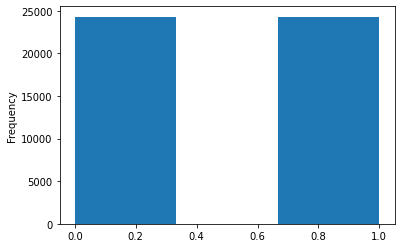

In [23]:
df_darkbalanced['Label'].plot(kind = 'hist', bins = 3)

In [24]:
train, test = train_test_split(df_darkbalanced, test_size=0.2)

In [25]:
def split_x_y(df):
  X = df[df.columns.difference(['Label'])]  #independent columns
  y = df['Label']    #target column i.e price range
  return X, y

In [45]:
train_X, train_y = split_x_y(train)
test_X, test_y = split_x_y(test)

In [84]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_X, train_y)

KNeighborsClassifier()

In [85]:
neigh.score(test_X, test_y)

0.9331619537275064

In [86]:
# clf = RandomForestClassifier(max_depth=5, random_state=0)
# clf.fit(train_X, train_y)
# clf.score(test_X, test_y)


In [87]:
# clf = MLPClassifier(random_state=1, max_iter=1000).fit(train_X, train_y)
# clf.score(test_X, test_y)

In [88]:
# pred_y = clf.predict(test_X)

In [89]:
pred_y = neigh.predict(test_X)

In [90]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

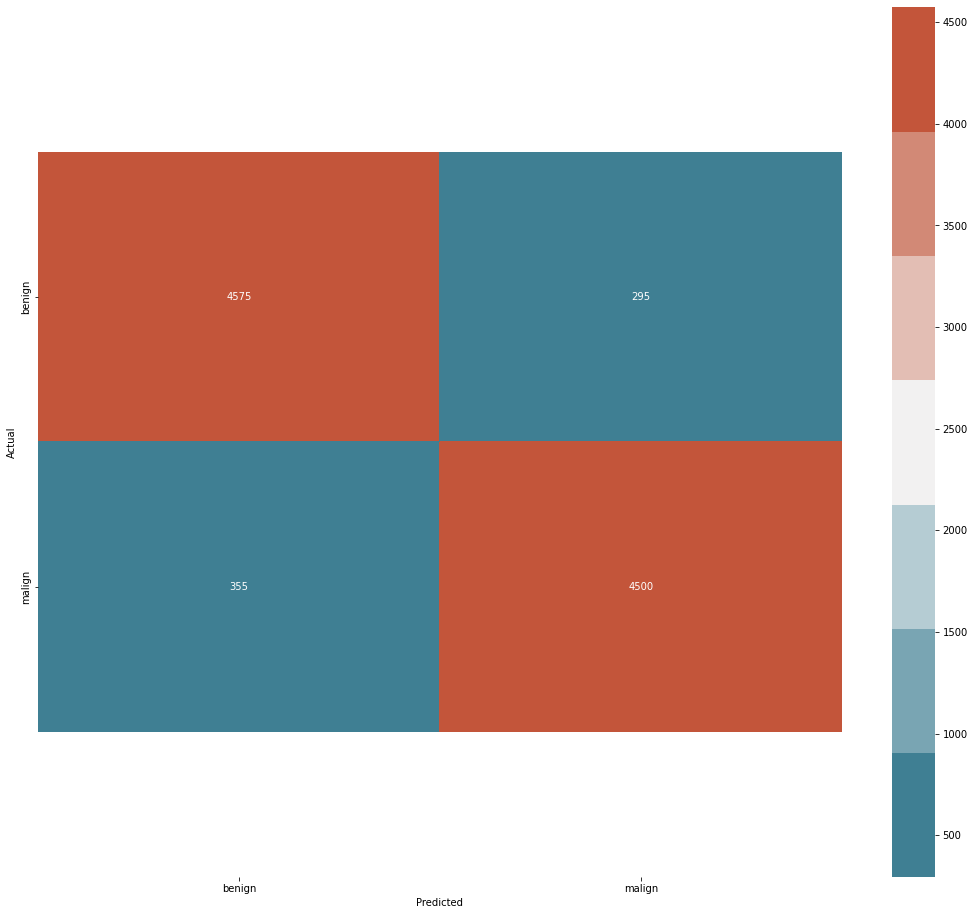

In [91]:
plot_cm(test_y, pred_y, ['benign', 'malign'])

In [92]:
from sklearn.metrics import f1_score
f1_score(test_y, pred_y, average='macro')

0.9331579782171937

In [93]:
precision_score(test_y, pred_y, average='macro')

0.9332347336115417

In [94]:
recall_score(test_y, pred_y, average='macro')

0.933152278499483

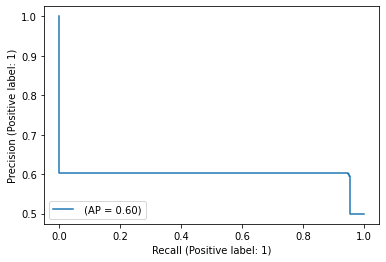

In [95]:
display = PrecisionRecallDisplay.from_estimator(clf, test_X, test_y, name="")

In [96]:
kf = KFold(n_splits=5)
kf.get_n_splits(test_X)

5

In [98]:
cross_val_score(neigh, train_X, train_y, cv=5, scoring='accuracy')

array([0.92866324, 0.9340617 , 0.93276771, 0.93469598, 0.93238205])